In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import os
import xlwt
from xlwt import *
from xlrd import open_workbook

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [2]:
model_name = "movenet_thunder" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

2022-03-06 21:04:58.117303: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# Follow the cosin rule to calulate the joint angles
def jointAngle(joint):
    (keypoint_locs, keypoint_edges, edge_colors) = _keypoints_and_edges_for_display(keypoint_with_scores, 1280, 1280)
    try:
        if joint in "left_elbow":
            a = np.array([keypoint_locs[5,1],keypoint_locs[5,0]])   #'left_shoulder': 5,
            b = np.array([keypoint_locs[7,1],keypoint_locs[7,0]])   #'left_elbow': 7,
            c = np.array([keypoint_locs[9,1],keypoint_locs[9,0]])  #'left_wrist': 9,
            
        elif joint in "right_elbow":
            a = np.array([keypoint_locs[6,1],keypoint_locs[6,0]])   #'right_shoulder': 6,
            b = np.array([keypoint_locs[8,1],keypoint_locs[8,0]])   #'right_elbow': 8,
            c = np.array([keypoint_locs[10,1],keypoint_locs[10,0]])  #'right_wrist': 10,

        elif joint in "left_shoulder":
            a = np.array([keypoint_locs[7,1],keypoint_locs[7,0]])   #'left_elbow': 7,
            b = np.array([keypoint_locs[5,1],keypoint_locs[5,0]])   #'left_shoulder': 5,
            c = np.array([keypoint_locs[11,1],keypoint_locs[11,0]]) #'left_hip': 11,

        elif joint in "left_hip":
            a = np.array([keypoint_locs[5,1],keypoint_locs[5,0]])   #'left_shoulder': 5, 
            b = np.array([keypoint_locs[11,1],keypoint_locs[11,0]]) #'left_hip': 11,
            c = np.array([keypoint_locs[13,1],keypoint_locs[13,0]]) #'left_knee': 13, 

        elif joint in "left_knee":
            a = np.array([keypoint_locs[11,1],keypoint_locs[11,0]]) #'left_hip': 11,
            b = np.array([keypoint_locs[13,1],keypoint_locs[13,0]]) #'left_knee': 13,
            c = np.array([keypoint_locs[15,1],keypoint_locs[15,0]]) #'left_ankle': 15, 

        elif joint in "right_shoulder":
            a = np.array([keypoint_locs[8,1],keypoint_locs[8,0]])   #'right_elbow': 8,
            b = np.array([keypoint_locs[6,1],keypoint_locs[6,0]])   #'right_shoulder': 6,
            c = np.array([keypoint_locs[12,1],keypoint_locs[12,0]]) #'right_hip': 12, 


        elif joint in "right_hip":
            a = np.array([keypoint_locs[6,1],keypoint_locs[6,0]])   #'right_shoulder': 6,
            b = np.array([keypoint_locs[12,1],keypoint_locs[12,0]]) #'right_hip': 12,
            c = np.array([keypoint_locs[14,1],keypoint_locs[14,0]]) #'right_knee': 14,

        elif joint in "right_knee":
            a = np.array([keypoint_locs[12,1],keypoint_locs[12,0]]) #'right_hip': 12,
            b = np.array([keypoint_locs[14,1],keypoint_locs[14,0]]) #'right_knee': 14,
            c = np.array([keypoint_locs[16,1],keypoint_locs[16,0]]) #'right_ankle': 16, 
    
    except IndexError as e: # catch the error
        print(e)  
        print("Ignore IndexError")
        a=0
        b=0
        c=0
    
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

Files and directories in ' /Users/zhuweiqin/Library/CloudStorage/Box-Box/JointAngleProject/JointAngle_Images/dl006/Frames-dl006_081.2104948.20220224083748/ ' :
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg', '108.jpg', '109.jpg', '11.jpg', '110.jpg', '111.jpg', '112.jpg', '113.jpg', '114.jpg', '115.jpg', '116.jpg', '117.jpg', '118.jpg', '119.jpg', '12.jpg', '120.jpg', '121.jpg', '122.jpg', '123.jpg', '124.jpg', '125.jpg', '126.jpg', '127.jpg', '128.jpg', '129.jpg', '13.jpg', '130.jpg', '131.jpg', '132.jpg', '133.jpg', '134.jpg', '135.jpg', '136.jpg', '137.jpg', '138.jpg', '139.jpg', '14.jpg', '140.jpg', '141.jpg', '142.jpg', '143.jpg', '144.jpg', '145.jpg', '146.jpg', '147.jpg', '148.jpg', '149.jpg', '15.jpg', '150.jpg', '151.jpg', '152.jpg', '153.jpg', '154.jpg', '155.jpg', '156.jpg', '157.jpg', '158.jpg', '159.jpg', '16.jpg', '160.jpg', '161.jpg', '162.jpg', '163.jpg', '164.jpg', '165.jpg', '166.jpg', '167.jpg', '16

/var/folders/c4/18pcqc1d2qj1g7gj_jztk1k80000gq/T/ipykernel_55668/2837780302.py:54: RuntimeWarning: invalid value encountered in true_divide
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))


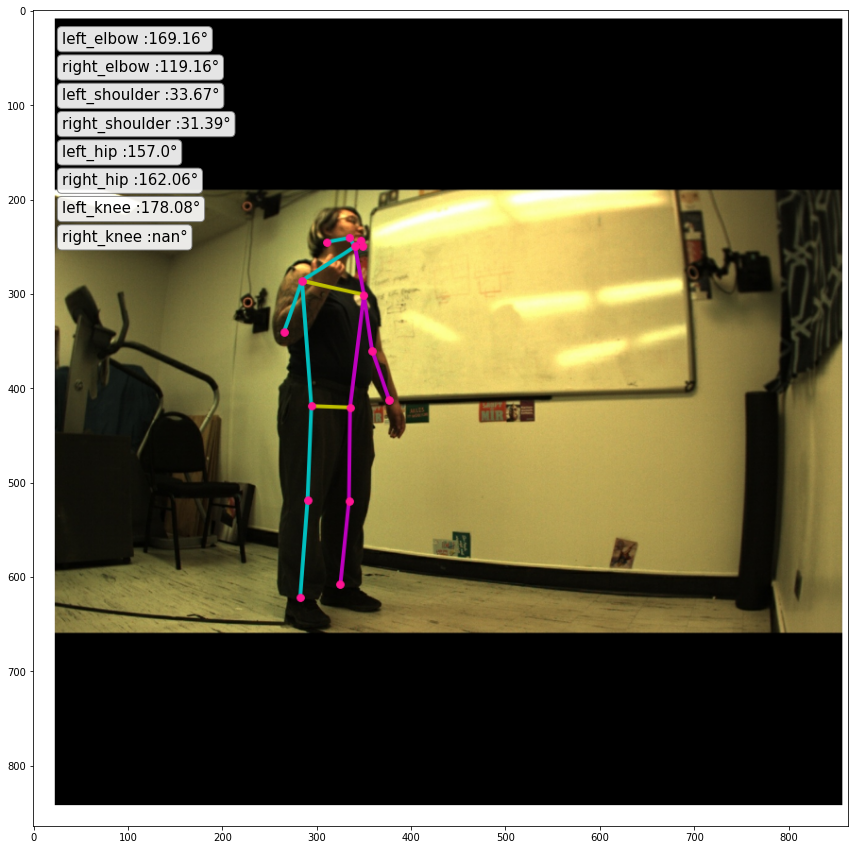

In [40]:
folder_name = "Frames-dl006_081.2104948.20220224083748"
path = "/Users/zhuweiqin/Library/CloudStorage/Box-Box/JointAngleProject/JointAngle_Images/dl006/"+folder_name+"/"

dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
img_files = list(filter(lambda x: '.jpg' in x, dir_list))
print(sorted(img_files))

joints = ["left_elbow", "right_elbow", "left_shoulder", "right_shoulder", "left_hip", "right_hip", "left_knee", "right_knee"]


# excel
# add_sheet is used to create sheet.
wb = Workbook()
sheet1 = wb.add_sheet('Angles')
row_num = 1
col_num =1

col_num_initilize = 1
for joint in joints:  
    sheet1.write(0, col_num_initilize, joint)
    col_num_initilize =col_num_initilize+1
    

imageFile = "241.jpg"
image_path = path+imageFile
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoint_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(display_image, 1280, 1280), dtype=tf.int32)

output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores, crop_region=None, close_figure=False, output_image_height=None)

fig= plt.figure(figsize=(15, 15))

# Output annotate
pix_index = 0 
for joint in joints:

    sheet1.write(row_num, col_num, float(str(round(jointAngle(joint),2))))
    col_num=col_num+1 #move to the nex col

    infor = joint + " :" + str(round(jointAngle(joint),2)) + "\N{DEGREE SIGN}"
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    # infor = "left_shoulder: "+ str(round(jointAngle("left_shoulder"),2))
    plt.text(30, 30 + pix_index*30, infor, ha="left", va="center", size=15, bbox=bbox_props)
    pix_index = pix_index+1

####
col_num=1 #back to the first col
row_num=row_num+1 #move to the next row
####

plt.draw()
plt.imshow(output_overlay)

isFile = os.path.isdir(path+"process/")
if not isFile:
    os.mkdir(path+"process/")
        
ImageName = path + "process/P_" + imageFile
plt.savefig(ImageName)

wb.save(path+"process/P_"+folder_name+".xls")

#excel sort function
target_column = 0     # This example only has 1 column, and it is 0 indexed
book = open_workbook(path+"process/P_"+folder_name+".xls")
sheet = book.sheets()[0]
data = [sheet.row_values(i) for i in range(sheet.nrows)]
labels = data[0]    # Don't sort our headers
data = data[1:]     # Data begins on the second row
data.sort(key=lambda x: x[target_column])

bk = xlwt.Workbook()
sheet = bk.add_sheet(sheet.name)

for idx, label in enumerate(labels):
     sheet.write(0, idx, label)

for idx_r, row in enumerate(data):
    for idx_c, value in enumerate(row):
        sheet.write(idx_r+1, idx_c, value)
bk.save(path+"process/P_"+folder_name+".xls")
#excel sort function